In [1]:
import numpy as np
import pickle

from consbi.simulators import (
    DistanceRuleSimulator, 
    RuleSimulator, 
    poisson_glm, 
    peters_rule_subcellular, 
    two_param_poisson_glm,
    default_rule_linear, 
    two_param_rule_dependent,
    dso_linear_two_param,
)
from consbi.simulators import default_rule
from torch.distributions import MultivariateNormal

from sbi.inference import prepare_for_sbi, simulate_for_sbi
from sbi.utils import BoxUniform

import torch
import matplotlib.pyplot as plt
plt.style.use('plotting_settings.mplstyle')
%matplotlib inline

In [2]:
# The prior will be Gaussian for most rules.
num_dim = 2
prior_scale = 3
prior = BoxUniform(torch.zeros(num_dim), prior_scale * torch.ones(num_dim))

## Poisson GLM

The problem is reduced to just 10 neuron-pair-subvolume combinations withtout summary statistics, i.e., the simulator returns the raw synapse counts sampled from a Poisson distribution. Thus, it is fast and tractable. 

In [3]:
theta = prior.sample((10000,))
x = two_param_poisson_glm(theta, offset=prior_scale)

Text(0.5, 0, 'Counts')

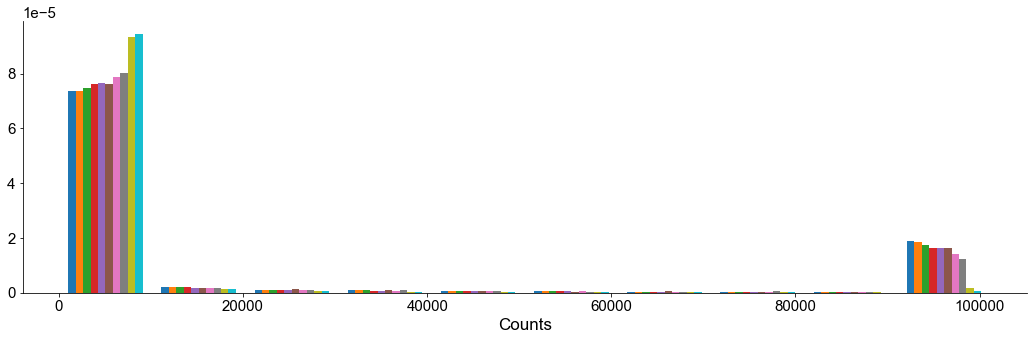

In [4]:
plt.figure(figsize=(18, 5))
plt.hist(x.numpy(), density=1)
plt.xlabel("Counts")
# plt.legend([f"neuron-pair-volume combi {ii}" for ii in range(10)]);

In [5]:
path_to_model = "../data/structural_model"
# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50
simulator = RuleSimulator(path_to_model, 
                          rule=default_rule_linear, 
                          verbose=True, 
                          num_subsampling_pairs=num_subsampling_pairs)

Loading features, this may take a while...
Time elapsed: 158.57700419425964


/home/janfb/qode/sbi-for-connectomics/consbi/simulators/rule_simulator.py:657: RuntimeWarning: invalid value encountered in log
  log_features = np.log(features)


constraint 0, num rows (with overlap) 2168393
constraint 1, num rows (with overlap) 687074
constraint 2, num rows (with overlap) 308345
constraint 3, num rows (with overlap) 674175
constraint 4, num rows (with overlap) 559727
constraint 5, num rows (with overlap) 587659
constraint 6, num rows (with overlap) 1096435


In [23]:
num_simulations = 100000
num_dim = 2
prior_scale = 3
prior = BoxUniform(torch.zeros(num_dim), prior_scale * torch.ones(num_dim))
from functools import partial

simulator.rule = two_param_rule_dependent

def batch_loop_simulator(theta):
        """Return a batch of simulations by looping over a batch of parameters."""
        assert theta.ndim > 1, "Theta must have a batch dimension."
        # Simulate in loop
        xs = list(map(simulator, theta))
        # Stack over batch to keep x_shape
        return torch.stack(xs)

# wrap the simulator to handle batches of parameters
batch_simulator, prior = prepare_for_sbi(batch_loop_simulator, prior)

In [ ]:
theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, 
                            num_workers=24, 
                            simulation_batch_size=100)


In [ ]:
# save prior predictive samples
with open(f"../results/prior_predictive_samples_dso_two_param_N{num_simulations}.p", "wb") as fh: 
    pickle.dump(dict(theta=theta, x=x), fh)

In [ ]:
x = x.squeeze()

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(12, 3), gridspec_kw=dict(wspace=0.15))
xo = np.array([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])

colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
num_bins = 15
data_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]

for ii in range(7):
    plt.sca(ax[ii])
    plt.hist(x[:, ii].numpy(), color=colors[6], bins=np.linspace(0, 1, num_bins), alpha=0.9)
    plt.axvline(xo[0, ii], color="k")
    plt.xticks(np.linspace(0,1,2))
    plt.xlim(0, 1)
    ax[ii].spines["right"].set_visible(False)
    ax[ii].spines["top"].set_visible(False)
    ax[ii].spines["left"].set_visible(False)
    plt.yticks([])
    plt.xlabel(data_labels[ii])
plt.legend(["measured", "simulated \nfrom prior"], bbox_to_anchor=(.11, .69), handlelength=1.0)

In [ ]:
from sbi.utils import pairplot
pairplot(x.numpy()[:10000,:], points=xo[0], upper="scatter", figsize=(18, 12), 
         points_offdiag=dict(marker="+"), 
         points_colors=["k"]
         
        );

In [ ]:
plt.savefig("prior_predictive.png", dpi=300, bbox_inches='tight')